In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [12]:
data = pd.read_csv('personal_transactions.csv')

https://www.kaggle.com/datasets/bukolafatunde/personal-finance?select=personal_transactions.csv

In [13]:
data.head()

,Date,Description,Amount,Transaction Type,Category,Account Name
0,01/01/2018,Amazon,11.11,debit,Shopping,Platinum Card
1,01/02/2018,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking
2,01/02/2018,Thai Restaurant,24.22,debit,Restaurants,Silver Card
3,01/03/2018,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card
4,01/04/2018,Netflix,11.76,debit,Movies & DVDs,Platinum Card


In [14]:
data.shape

(806, 6)

In [15]:
data.dtypes

Date                 object
Description          object
Amount              float64
Transaction Type     object
Category             object
Account Name         object
dtype: object

In [16]:
from dateutil import parser
data['Date'] = data['Date'].apply(parser.parse)

In [17]:
data.describe()

,Amount
count,806.000000
mean,273.391489
std,667.630374
min,1.750000
25%,15.687500
50%,37.480000
75%,117.680000
max,9200.000000


In [18]:
data.describe(include='object')

,Description,Transaction Type,Category,Account Name
count,806,806,806,806
unique,65,2,22,3
top,Credit Card Payment,debit,Credit Card Payment,Platinum Card
freq,143,688,143,366


In [19]:
data['Category'].value_counts()

Credit Card Payment       143
Groceries                 105
Restaurants                81
Utilities                  63
Shopping                   60
Gas & Fuel                 52
Paycheck                   46
Home Improvement           36
Coffee Shops               31
Alcohol & Bars             25
Music                      21
Mobile Phone               21
Mortgage & Rent            21
Internet                   21
Movies & DVDs              18
Auto Insurance             18
Fast Food                  16
Haircut                    13
Television                  8
Electronics & Software      4
Food & Dining               2
Entertainment               1
Name: Category, dtype: int64

In [20]:
data.isnull().sum()

Date                0
Description         0
Amount              0
Transaction Type    0
Category            0
Account Name        0
dtype: int64

In [21]:
data[data.duplicated()]

,Date,Description,Amount,Transaction Type,Category,Account Name


In [22]:
negative_amounts = data[(data['Transaction Type'] == 'credit') & (data['Amount'] < 0)]
valid_transaction_types = ['debit', 'credit']
invalid_transaction_types = data[~data['Transaction Type'].isin(valid_transaction_types)]
invalid_categories = data['Category'].isnull() | data['Category'].str.strip().eq("")
cleaning_issues = {
    "negative_amounts": negative_amounts,
    "invalid_transaction_types": invalid_transaction_types,
    "invalid_categories": invalid_categories.sum(),
}

cleaning_issues

{'negative_amounts': Empty DataFrame
 Columns: [Date, Description, Amount, Transaction Type, Category, Account Name]
 Index: [],
 'invalid_transaction_types': Empty DataFrame
 Columns: [Date, Description, Amount, Transaction Type, Category, Account Name]
 Index: [],
 'invalid_categories': 0}

In [23]:
data['NetBalance'] = data.apply(
    lambda x: x['Amount'] if x['Transaction Type'] == 'credit' else -x['Amount'], axis=1
)
data['NetBalance']

0       -11.11
1     -1247.44
2       -24.22
3      2298.09
4       -11.76
        ...   
801    2250.00
802     -33.46
803      -4.27
804      -1.75
805     -75.00
Name: NetBalance, Length: 806, dtype: float64

In [24]:
data['Month'] = pd.to_datetime(data['Date']).dt.to_period('M')

In [25]:
# Grouper par mois pour les revenus et dépenses
monthly_summary = data.groupby('Month').agg(
    Total_Revenues=('Amount', lambda x: x[data['Transaction Type'] == 'credit'].sum()),
    Total_Expenses=('Amount', lambda x: x[data['Transaction Type'] == 'debit'].sum())
).reset_index()

# Grouper par catégorie et mois pour les revenus et dépenses
category_monthly_summary = data.groupby(['Category', 'Month']).agg(
    Category_Revenues=('Amount', lambda x: x[data['Transaction Type'] == 'credit'].sum()),
    Category_Expenses=('Amount', lambda x: x[data['Transaction Type'] == 'debit'].sum())
).reset_index()

# Joindre les résultats dans la dataframe principale
data = pd.merge(data, monthly_summary, on='Month', how='left')
data = pd.merge(data, category_monthly_summary, on=['Category', 'Month'], how='left')

# Afficher le résultat
data.head()


,Date,Description,Amount,Transaction Type,Category,Account Name,NetBalance,Month,Total_Revenues,Total_Expenses,Category_Revenues,Category_Expenses
0,2018-01-01,Amazon,11.11,debit,Shopping,Platinum Card,-11.11,2018-01,7162.89,2931.45,0.00,100.37
1,2018-01-02,Mortgage Payment,1247.44,debit,Mortgage & Rent,Checking,-1247.44,2018-01,7162.89,2931.45,0.00,1247.44
2,2018-01-02,Thai Restaurant,24.22,debit,Restaurants,Silver Card,-24.22,2018-01,7162.89,2931.45,0.00,156.80
3,2018-01-03,Credit Card Payment,2298.09,credit,Credit Card Payment,Platinum Card,2298.09,2018-01,7162.89,2931.45,3162.89,864.80
4,2018-01-04,Netflix,11.76,debit,Movies & DVDs,Platinum Card,-11.76,2018-01,7162.89,2931.45,0.00,11.76


In [26]:
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfMonth'] = data['Date'].dt.day
data['Year'] = data['Date'].dt.year

In [27]:
data['Previous_Month_Revenues'] = data.groupby('Month')['Total_Revenues'].shift(1)
data['Previous_Month_Expenses'] = data.groupby('Month')['Total_Expenses'].shift(1)

# 3. Solde net précédent (même logique que pour les revenus/dépenses)
data['Previous_NetBalance'] = data['NetBalance'].shift(1)

# 4. Moyenne mobile des revenus/dépenses sur 3 mois (exemple)
data['Rolling_Revenues_3M'] = data['Total_Revenues'].rolling(window=3).mean()
data['Rolling_Expenses_3M'] = data['Total_Expenses'].rolling(window=3).mean()

In [28]:
data = pd.get_dummies(data, columns=['Category'], drop_first=True)
data['Transaction_Type_Encoded'] = data['Transaction Type'].apply(lambda x: 1 if x == 'credit' else 0)


In [29]:
data.isnull().sum()

Date                                0
Description                         0
Amount                              0
Transaction Type                    0
Account Name                        0
NetBalance                          0
Month                               0
Total_Revenues                      0
Total_Expenses                      0
Category_Revenues                   0
Category_Expenses                   0
DayOfWeek                           0
DayOfMonth                          0
Year                                0
Previous_Month_Revenues            21
Previous_Month_Expenses            21
Previous_NetBalance                 1
Rolling_Revenues_3M                 2
Rolling_Expenses_3M                 2
Category_Auto Insurance             0
Category_Coffee Shops               0
Category_Credit Card Payment        0
Category_Electronics & Software     0
Category_Entertainment              0
Category_Fast Food                  0
Category_Food & Dining              0
Category_Gas

In [30]:
print(data['Month'].unique())

<PeriodArray>
['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
 '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
 '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09']
Length: 21, dtype: period[M]


In [31]:
def impute_with_previous_year_average(dataframe, column):
    # Créer une colonne 'Year_Month' qui combine l'année et le mois
    dataframe['Year_Month'] = dataframe['Date'].dt.to_period('M')

    # Créez une nouvelle colonne avec les valeurs de l'année précédente
    dataframe['Previous_Year'] = dataframe['Year'] - 1
    dataframe['Previous_Year_Month'] = dataframe['Previous_Year'].astype(str) + '-' + dataframe['Month'].astype(str).str.zfill(2)

    # Calculer la moyenne des valeurs pour chaque mois de l'année précédente
    previous_year_avg = dataframe.groupby('Previous_Year_Month')[column].mean()

    # Imputer les valeurs manquantes avec la moyenne de l'année précédente et du même mois
    dataframe[column] = dataframe.apply(
        lambda row: previous_year_avg.get(row['Previous_Year_Month'], row[column])
        if pd.isna(row[column]) else row[column],
        axis=1
    )

    return dataframe
data = impute_with_previous_year_average(data, 'Previous_Month_Revenues')
data = impute_with_previous_year_average(data, 'Previous_Month_Expenses')
data = impute_with_previous_year_average(data, 'Rolling_Revenues_3M')
data = impute_with_previous_year_average(data, 'Rolling_Expenses_3M')
data = impute_with_previous_year_average(data, 'Previous_NetBalance')

In [32]:
data.isnull().sum()

Date                               0
Description                        0
Amount                             0
Transaction Type                   0
Account Name                       0
NetBalance                         0
Month                              0
Total_Revenues                     0
Total_Expenses                     0
Category_Revenues                  0
Category_Expenses                  0
DayOfWeek                          0
DayOfMonth                         0
Year                               0
Previous_Month_Revenues            0
Previous_Month_Expenses            0
Previous_NetBalance                0
Rolling_Revenues_3M                0
Rolling_Expenses_3M                0
Category_Auto Insurance            0
Category_Coffee Shops              0
Category_Credit Card Payment       0
Category_Electronics & Software    0
Category_Entertainment             0
Category_Fast Food                 0
Category_Food & Dining             0
Category_Gas & Fuel                0
C

In [33]:
# Sélectionner les variables liées aux revenus sans les catégories encodées
revenues_columns = [
    'Total_Revenues', 'Rolling_Revenues_3M',
    'Previous_Month_Revenues', 'Previous_NetBalance'
]

# Sélectionner les variables liées aux dépenses sans les catégories encodées
expenses_columns = [
    'Total_Expenses', 'Rolling_Expenses_3M',
    'Previous_Month_Expenses', 'Previous_NetBalance'
]

# Sélectionner les données correspondantes aux revenus
revenues_data = data[revenues_columns].select_dtypes(include=['float64', 'int32', 'int64'])

# Sélectionner les données correspondantes aux dépenses
expenses_data = data[expenses_columns].select_dtypes(include=['float64', 'int32', 'int64'])

# Calculer la corrélation pour les revenus
correlation_matrix_revenues = revenues_data.corr()

# Calculer la corrélation pour les dépenses
correlation_matrix_expenses = expenses_data.corr()



In [34]:
correlation_matrix_expenses

,Total_Expenses,Rolling_Expenses_3M,Previous_Month_Expenses,Previous_NetBalance
Total_Expenses,1.000000,0.986927,1.000000,-0.102204
Rolling_Expenses_3M,0.986927,1.000000,0.986927,-0.103285
Previous_Month_Expenses,1.000000,0.986927,1.000000,-0.102204
Previous_NetBalance,-0.102204,-0.103285,-0.102204,1.000000


In [35]:
correlation_matrix_revenues

,Total_Revenues,Rolling_Revenues_3M,Previous_Month_Revenues,Previous_NetBalance
Total_Revenues,1.000000,0.983510,1.000000,0.053929
Rolling_Revenues_3M,0.983510,1.000000,0.983510,0.056888
Previous_Month_Revenues,1.000000,0.983510,1.000000,0.053929
Previous_NetBalance,0.053929,0.056888,0.053929,1.000000


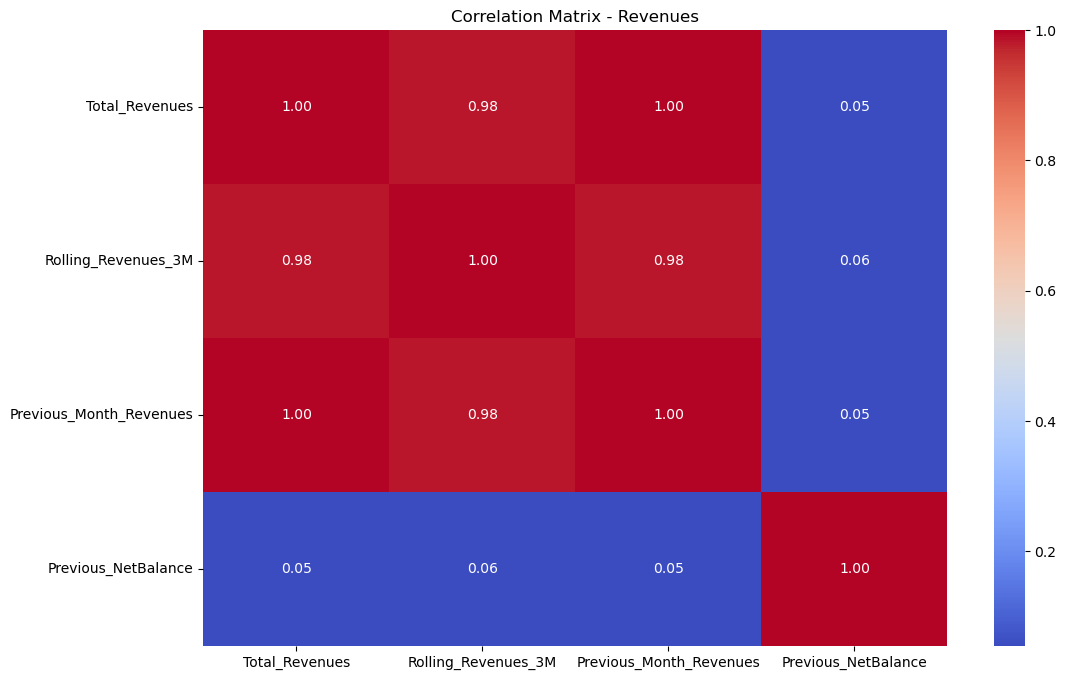

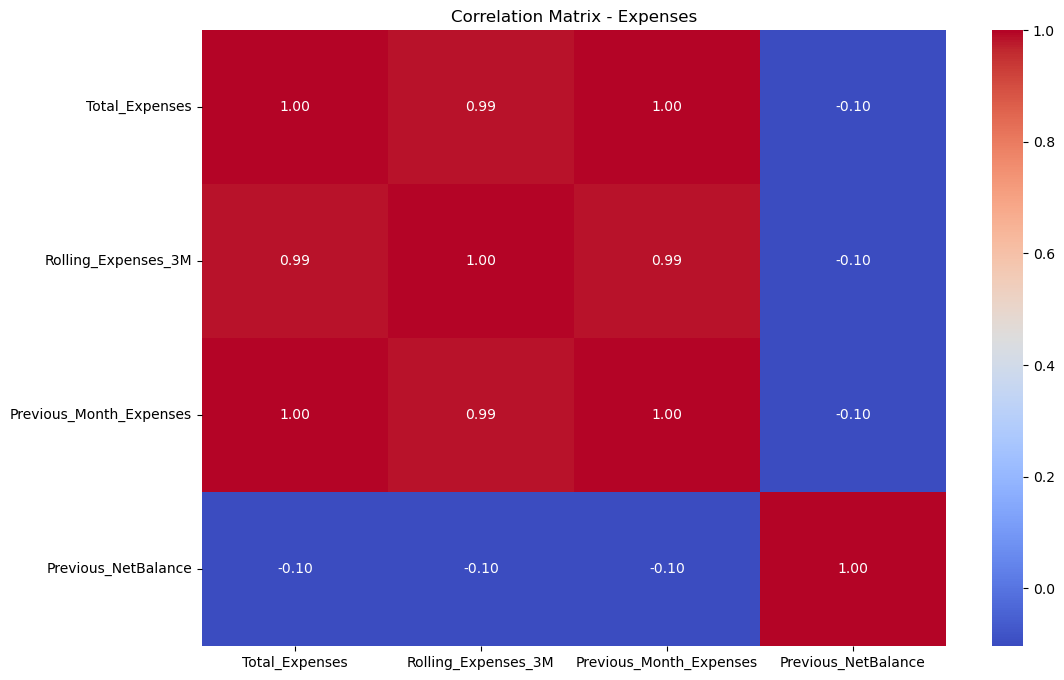

In [36]:
# Visualisation avec une heatmap pour les revenus
import seaborn as sns
import matplotlib.pyplot as plt

# Revenus
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_revenues, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix - Revenues")
plt.show()

# Dépenses
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_expenses, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix - Expenses")
plt.show()


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [38]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Détection des outliers pour les revenus et dépenses
outliers_revenues = detect_outliers_iqr(data, 'Total_Revenues')
outliers_expenses = detect_outliers_iqr(data, 'Total_Expenses')
print(outliers_expenses)


          Date                Description   Amount Transaction Type  \
156 2018-05-01                     Amazon    13.13            debit   
157 2018-05-02           Mortgage Payment  1247.44            debit   
158 2018-05-03                     Amazon    49.72            debit   
159 2018-05-04              Grocery Store    42.23            debit   
160 2018-05-04                    Netflix    11.76            debit   
..         ...                        ...      ...              ...   
678 2019-06-21        Credit Card Payment   100.68            debit   
679 2019-06-21          Biweekly Paycheck  2000.00           credit   
680 2019-06-24            Brewing Company    15.00            debit   
681 2019-06-28                         BP    30.64            debit   
682 2019-06-30  Internet Service Provider    75.00            debit   

      Account Name  NetBalance    Month  Total_Revenues  Total_Expenses  \
156  Platinum Card      -13.13  2018-05         5091.55        11392.03 

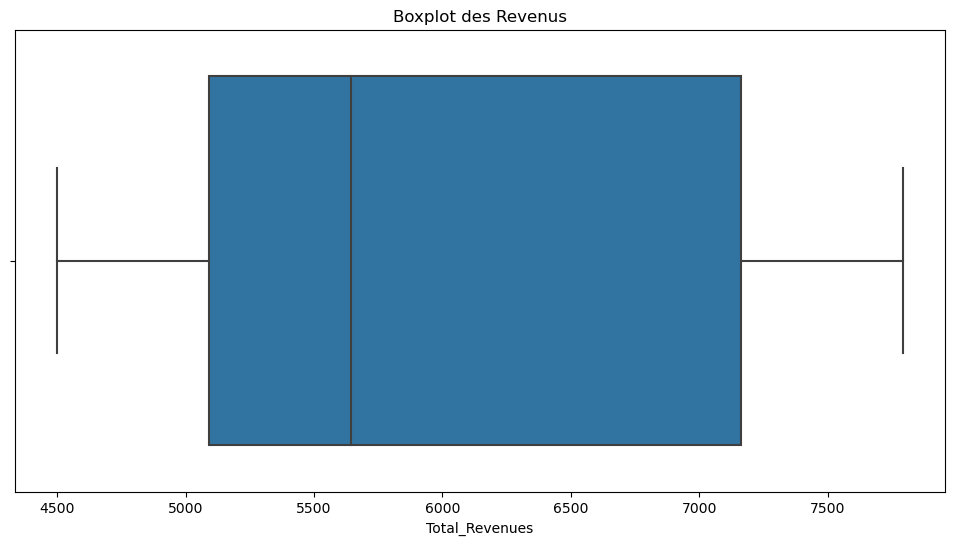

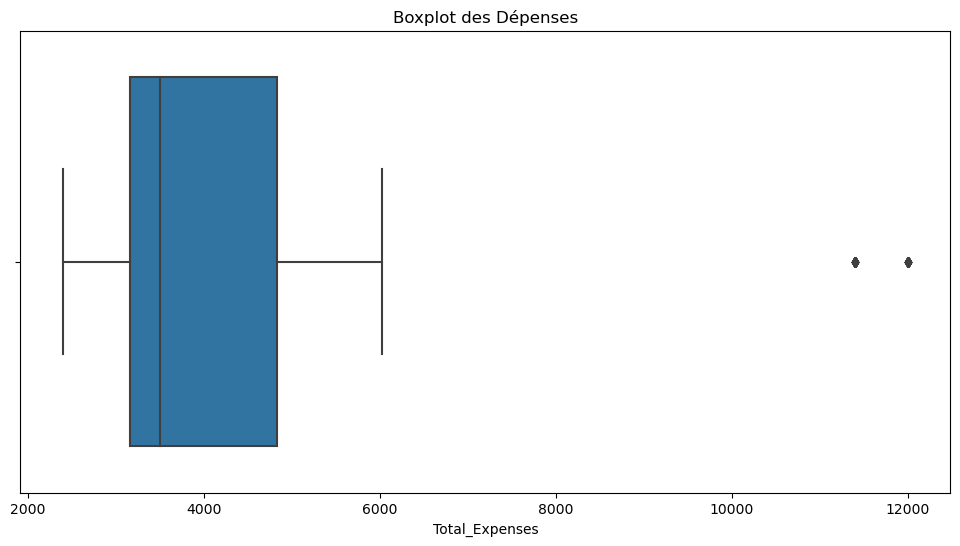

In [39]:
# 2. Visualisation des outliers avec un boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Total_Revenues'])
plt.title('Boxplot des Revenus')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=data['Total_Expenses'])
plt.title('Boxplot des Dépenses')
plt.show()

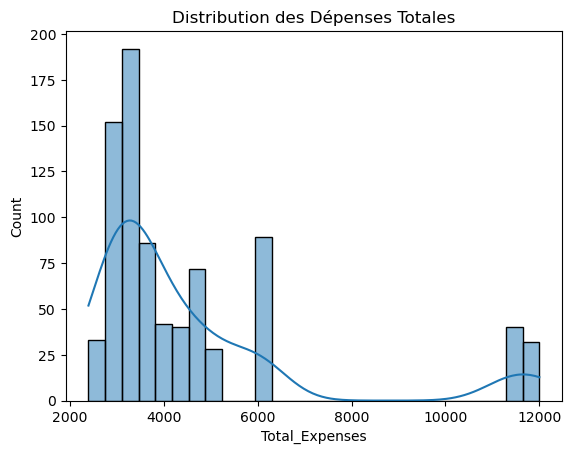

In [40]:
sns.histplot(data['Total_Expenses'], kde=True)
plt.title("Distribution des Dépenses Totales")
plt.show()


In [41]:
median_expenses = data['Total_Expenses'].median()
data['Total_Expenses'] = np.where(
    data['Total_Expenses'].isin(outliers_expenses['Total_Expenses']),
    median_expenses,
    data['Total_Expenses']
)

In [42]:
data

,Date,Description,Amount,Transaction Type,Account Name,NetBalance,Month,Total_Revenues,Total_Expenses,Category_Revenues,...,Category_Music,Category_Paycheck,Category_Restaurants,Category_Shopping,Category_Television,Category_Utilities,Transaction_Type_Encoded,Year_Month,Previous_Year,Previous_Year_Month
0,2018-01-01,Amazon,11.11,debit,Platinum Card,-11.11,2018-01,7162.89,2931.45,0.00,...,0,0,0,1,0,0,0,2018-01,2017,2017-2018-01
1,2018-01-02,Mortgage Payment,1247.44,debit,Checking,-1247.44,2018-01,7162.89,2931.45,0.00,...,0,0,0,0,0,0,0,2018-01,2017,2017-2018-01
2,2018-01-02,Thai Restaurant,24.22,debit,Silver Card,-24.22,2018-01,7162.89,2931.45,0.00,...,0,0,1,0,0,0,0,2018-01,2017,2017-2018-01
3,2018-01-03,Credit Card Payment,2298.09,credit,Platinum Card,2298.09,2018-01,7162.89,2931.45,3162.89,...,0,0,0,0,0,0,1,2018-01,2017,2017-2018-01
4,2018-01-04,Netflix,11.76,debit,Platinum Card,-11.76,2018-01,7162.89,2931.45,0.00,...,0,0,0,0,0,0,0,2018-01,2017,2017-2018-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,2019-09-27,Biweekly Paycheck,2250.00,credit,Checking,2250.00,2019-09,6537.06,5998.42,4500.00,...,0,1,0,0,0,0,1,2019-09,2018,2018-2019-09
802,2019-09-28,BP,33.46,debit,Platinum Card,-33.46,2019-09,6537.06,5998.42,0.00,...,0,0,0,0,0,0,0,2019-09,2018,2018-2019-09
803,2019-09-28,Sheetz,4.27,debit,Platinum Card,-4.27,2019-09,6537.06,5998.42,0.00,...,0,0,0,0,0,0,0,2019-09,2018,2018-2019-09
804,2019-09-30,Starbucks,1.75,debit,Platinum Card,-1.75,2019-09,6537.06,5998.42,0.00,...,0,0,0,0,0,0,0,2019-09,2018,2018-2019-09


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_revenues = data[['Previous_Month_Revenues', 'Rolling_Revenues_3M', 'Previous_NetBalance'] ]
y_revenues = data['Total_Revenues']
X_train_revenues, X_test_revenues, y_train_revenues, y_test_revenues = train_test_split(X_revenues, y_revenues, test_size=0.2, random_state=42)


In [44]:
# Variables d'entrée pour les dépenses (inclure uniquement les colonnes pertinentes pour les dépenses)
X_expenses = data[['Previous_Month_Expenses', 'Rolling_Expenses_3M', 'Previous_NetBalance'] ]
y_expenses = data['Total_Expenses']
X_train_expenses, X_test_expenses, y_train_expenses, y_test_expenses = train_test_split(X_expenses, y_expenses, test_size=0.2, random_state=42)

#

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Définir le modèle RandomForest
rf_model_expenses = RandomForestRegressor(random_state=42)

# Définir la grille de paramètres à tester pour n_estimators et max_depth
param_grid = {
    'n_estimators': [50, 100, 200],  # Essayer différents nombres d'arbres
    'max_depth': [10, 20, 30, None],  # Limiter la profondeur des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4]     # Nombre minimal d'échantillons par feuille
}

# Appliquer la recherche sur la grille avec validation croisée (cross-validation)
grid_search = GridSearchCV(estimator=rf_model_expenses, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Entraîner le modèle avec GridSearchCV
grid_search.fit(X_train_expenses, y_train_expenses)

# Afficher les meilleurs paramètres trouvés par GridSearchCV
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Utiliser les meilleurs paramètres pour prédire avec le modèle
best_rf_model_expenses = grid_search.best_estimator_

# Faire des prédictions sur l'ensemble de test
y_pred_expenses_rf = best_rf_model_expenses.predict(X_test_expenses)

# Évaluation du modèle
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Model Evaluation:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    print()

# Évaluation des dépenses
evaluate_model(y_test_expenses, y_pred_expenses_rf, "Dépenses avec RandomForest")

# Afficher le score sur l'ensemble de test
score_rf_expenses = best_rf_model_expenses.score(X_test_expenses, y_test_expenses)
print(f"Score (R²) sur l'ensemble de test : {score_rf_expenses:.4f}")


Meilleurs paramètres : {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Dépenses avec RandomForest Model Evaluation:
MAE: 6.4725
MSE: 1256.3320
R²: 0.9986

Score (R²) sur l'ensemble de test : 0.9986


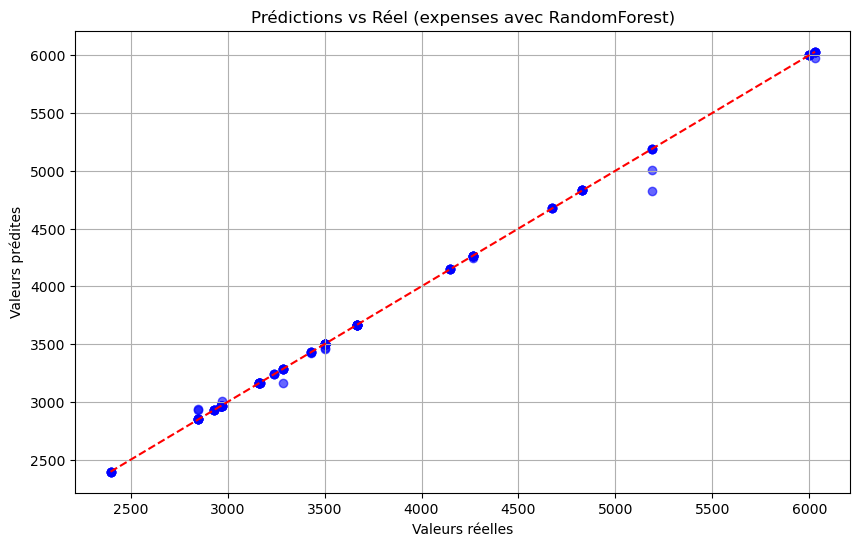

In [47]:
import matplotlib.pyplot as plt

# Tracer les valeurs réelles vs les valeurs prédites pour les revenus
plt.figure(figsize=(10, 6))
plt.scatter(y_test_expenses, y_pred_expenses_rf, color='blue', alpha=0.6)
plt.plot([y_test_expenses.min(), y_test_expenses.max()],
         [y_test_expenses.min(), y_test_expenses.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Réel (expenses avec RandomForest)')
plt.grid(True)
plt.show()

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Définir le modèle RandomForest pour les revenus
rf_model_revenues = RandomForestRegressor(random_state=42)

# Définir la grille de paramètres à tester pour n_estimators et max_depth
param_grid_revenues = {
    'n_estimators': [50, 100, 200],  # Essayer différents nombres d'arbres
    'max_depth': [10, 20, 30, None],  # Limiter la profondeur des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimal d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4]     # Nombre minimal d'échantillons par feuille
}

# Appliquer la recherche sur la grille avec validation croisée (cross-validation)
grid_search_revenues = GridSearchCV(estimator=rf_model_revenues, param_grid=param_grid_revenues,
                                    cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Entraîner le modèle avec GridSearchCV
grid_search_revenues.fit(X_train_revenues, y_train_revenues)

# Afficher les meilleurs paramètres trouvés par GridSearchCV
print(f"Meilleurs paramètres pour les revenus : {grid_search_revenues.best_params_}")

# Utiliser les meilleurs paramètres pour prédire avec le modèle
best_rf_model_revenues = grid_search_revenues.best_estimator_

# Faire des prédictions sur l'ensemble de test
y_pred_revenues_rf = best_rf_model_revenues.predict(X_test_revenues)

# Évaluation du modèle
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name} Model Evaluation:")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"R²: {r2_score(y_true, y_pred):.4f}")
    print()

# Évaluation des revenus
evaluate_model(y_test_revenues, y_pred_revenues_rf, "Revenus avec RandomForest")

# Afficher le score sur l'ensemble de test
score_rf_revenues = best_rf_model_revenues.score(X_test_revenues, y_test_revenues)
print(f"Score (R²) sur l'ensemble de test pour les revenus : {score_rf_revenues:.4f}")


Meilleurs paramètres pour les revenus : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Revenus avec RandomForest Model Evaluation:
MAE: 1.3965
MSE: 49.6976
R²: 1.0000

Score (R²) sur l'ensemble de test pour les revenus : 1.0000


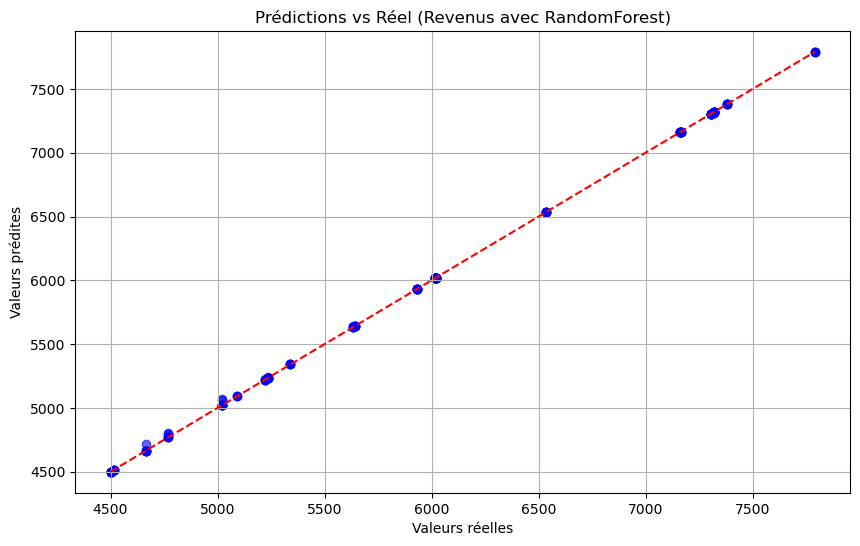

In [59]:
import matplotlib.pyplot as plt

# Tracer les valeurs réelles vs les valeurs prédites pour les revenus
plt.figure(figsize=(10, 6))
plt.scatter(y_test_revenues, y_pred_revenues_rf, color='blue', alpha=0.6)
plt.plot([y_test_revenues.min(), y_test_revenues.max()],
         [y_test_revenues.min(), y_test_revenues.max()], color='red', linestyle='--')
plt.xlabel('Valeurs réelles')
plt.ylabel('Valeurs prédites')
plt.title('Prédictions vs Réel (Revenus avec RandomForest)')
plt.grid(True)
plt.show()


In [1]:
import nest_asyncio
from fastapi import FastAPI
from pydantic import BaseModel
import mysql.connector
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from fastapi.middleware.cors import CORSMiddleware

# Permettre à FastAPI de fonctionner dans un notebook
nest_asyncio.apply()

# Création de l'application FastAPI
app = FastAPI()

# Ajouter le middleware CORS pour autoriser les requêtes depuis d'autres domaines
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # Ajustez cette liste si vous voulez restreindre les origines autorisées
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

# Définition du modèle de demande pour obtenir les prédictions
class UserRequest(BaseModel):
    user_id: int

@app.post("/get_predictions")
async def get_predictions(request: UserRequest):
    return {"message": "Success"}
    user_id = request.user_id
    try:
        # Connexion à la base de données MySQL
        with mysql.connector.connect(
            host='localhost',
            user='root',
            password='',
            database='budget'
        ) as connection:
            query_test = f"SELECT * FROM test_data WHERE user_id = {user_id} LIMIT 1;"
            data_test = pd.read_sql(query_test, connection)

        # Vérifier si les données existent pour l'utilisateur
        if data_test.empty:
            return {"error": "No data found for the user"}

        # Prédictions des revenus
        test_data_revenues = data_test[['Previous_Month_Revenues', 'Rolling_Revenues_3M', 'Previous_NetBalance']]
        best_rf_model_revenues = RandomForestRegressor()
        predicted_revenue = best_rf_model_revenues.predict(test_data_revenues)

        # Prédictions des dépenses
        test_data_expenses = data_test[['Previous_Month_Expenses', 'Rolling_Expenses_3M', 'Previous_NetBalance']]
        best_rf_model_expenses = RandomForestRegressor()
        predicted_expense = best_rf_model_expenses.predict(test_data_expenses)

        return {
            'predicted_revenue': predicted_revenue[0],
            'predicted_expense': predicted_expense[0]
        }

    except mysql.connector.Error as db_err:
        return {"error": f"Database error: {str(db_err)}"}
    except Exception as e:
        return {"error": f"An unexpected error occurred: {str(e)}"}

# Lancer FastAPI sur un port spécifique
import uvicorn
from threading import Thread

def run():
    uvicorn.run(app, host="127.0.0.1", port=8000)

thread = Thread(target=run)
thread.start()


INFO:     Started server process [1488]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:52034 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52035 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:52038 - "GET /get_predictions HTTP/1.1" 405 Method Not Allowed
